# Neural Networks

## Step 0: Project Setup

### Importing the Libraries 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import precision_score, recall_score

import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 

### Importing the Dataset

In [53]:
import sys
import os
import pandas as pd

# To allow for importing of 'utils' module from parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from utils import import_data

dataset_path = "../data"
dataset_version = "automated-v1.0"

automated_dataset = import_data(dataset_path, dataset_version)

automated_dataframe = automated_dataset["dataframe"]

X = automated_dataframe.iloc[:, :-1]  # All columns except the last one
y = automated_dataframe.iloc[:, -1]  # The last column

# Dropped upload times because pre-processing too much work (calculating std)
X = X.drop(columns=['mediaUpload_times'])

## Step 1: Data Preprocessing & Scaling

### Data Preproccessing

In [54]:
X['media_comment_numbers'] = X['media_comment_numbers'].apply(lambda i: np.mean(i) if len(i) > 0 else 0)
X['media_hashtag_numbers'] = X['media_hashtag_numbers'].apply(lambda i: np.mean(i) if len(i) > 0 else 0)
X['media_like_numbers'] = X['media_like_numbers'].apply(lambda i: np.mean(i) if len(i) > 0 else 0)

# binary features to be summed
X['media_comments_are_disabled'] = X['media_comments_are_disabled'].apply(np.sum)
X['media_has_location_info'] = X['media_has_location_info'].apply(np.sum)

### Data Splitting

In [56]:
# Splitting the dataset (20% Testing, 20% Validating, 60% Training)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,   
    test_size = 0.2, random_state=42, shuffle=True, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size = 0.25, random_state=42, shuffle=True, stratify=y_train_val
)

print(np.unique(y_train, return_counts=True))

# Check if splits are correct
print('X_train:' + str(X_train.shape))
print('y_train:' + str(y_train.shape))
print('X_val: \t'  + str(X_val.shape))
print('y_val: \t'  + str(y_val.shape))
print('X_test: '  + str(X_test.shape))
print('y_test: '  + str(y_test.shape))

(array([0, 1], dtype=int64), array([420, 420], dtype=int64))
X_train:(840, 15)
y_train:(840,)
X_val: 	(280, 15)
y_val: 	(280,)
X_test: (280, 15)
y_test: (280,)


### Data Scaling

In [57]:
# Scale Input Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train[0:2])

[[-0.47053333 -0.04059714  3.32524774 -0.96720415 -0.66580701 -0.03792806
  -0.05718309  1.64736904  1.05241263 -0.33696283 -0.0172352  -0.08145478
  -0.48359663 -0.70042572  0.00538244]
 [-0.10630055 -0.05354655 -0.72847212 -0.96720415 -0.66580701 -0.03784087
  -0.05571236 -1.12061692  0.27170029 -0.33696283 -0.22427415 -0.08145478
  -0.30914672 -0.54908037 -0.06312787]]


## Step 2: Data Transformations

### The neural network will be run on the following configurations:

- a) **3 Layers (14 -> 32 -> 1) [sigmoid, reLu, tanh]**
- b) **3 Layers (14 -> 64 -> 1) [sigmoid]**
- c) **3 Layers (14 -> 128 -> 1) [sigmoid]**
- d) **4 Layers (14 -> 64 -> 64 -> 1) [sigmoid]**
- e) **5 Layers (14 -> 64 -> 64 -> 64 -> 1) [sigmoid]**


Training Function

In [85]:
def train_nn(config, activation, alpha):

    table_results = []
    train_accuracies = []
    val_accuracies = []

    for a in alpha:

        nn_model = MLPClassifier(hidden_layer_sizes=config, activation=activation, 
                    solver='adam', alpha=a, max_iter=2000, random_state=42)
        
        # Fit / Train model
        nn_model.fit(X_train, y_train)

        # Train Accuracy
        train_prediction = nn_model.predict(X_train)
        train_accuracy = np.mean(train_prediction == y_train)
        train_accuracies.append(train_accuracy)

        # Validation Accuracy
        val_prediction = nn_model.predict(X_val)
        val_accuracy = np.mean(val_prediction == y_val)
        val_accuracies.append(val_accuracy)

        # Precision
        train_precision = precision_score(y_train, train_prediction, zero_division=0)
        val_precision = precision_score(y_val, val_prediction, zero_division=0)
        
        # Recall
        train_recall = recall_score(y_train, train_prediction)
        val_recall = recall_score(y_val, val_prediction)
    
        table_results.append({
            'Alpha': a,
            'Train Accuracy': train_accuracy,
            'Validation Accuracy': val_accuracy,
            'Train Precision': train_precision,
            'Validation Precision': val_precision,
            'Train Recall': train_recall,
            'Validation Recall': val_recall
        })

    # Convert to DataFrame
    result = pd.DataFrame(table_results)

    # Display
    print(result)

        # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(alpha, train_accuracies, marker='o', label='Train Accuracy')
    plt.plot(alpha, val_accuracies, marker='o', label='Validation Accuracy')
    plt.xscale('log')  # Because C is usually plotted on a log scale
    plt.xlabel('C (Regularization Strength)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Regularization (C) for SVM')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


alpha respresents L2 regularization (weight decay)

In [86]:
alpha = [0, 0.00001, .0001, 0.001, 0.01, 0.1, 1, 10]

### a1) 3 Layer (14 -> 32 -> 1) - sigmoid

      Alpha  Train Accuracy  Validation Accuracy  Train Precision  \
0   0.00000        0.908333             0.914286         0.925558   
1   0.00001        0.908333             0.914286         0.925558   
2   0.00010        0.908333             0.914286         0.925558   
3   0.00100        0.908333             0.914286         0.925558   
4   0.01000        0.910714             0.917857         0.925926   
5   0.10000        0.910714             0.914286         0.930175   
6   1.00000        0.897619             0.903571         0.923858   
7  10.00000        0.867857             0.850000         0.925620   

   Validation Precision  Train Recall  Validation Recall  
0              0.960317      0.888095           0.864286  
1              0.960317      0.888095           0.864286  
2              0.960317      0.888095           0.864286  
3              0.960317      0.888095           0.864286  
4              0.960630      0.892857           0.871429  
5              0.960317 

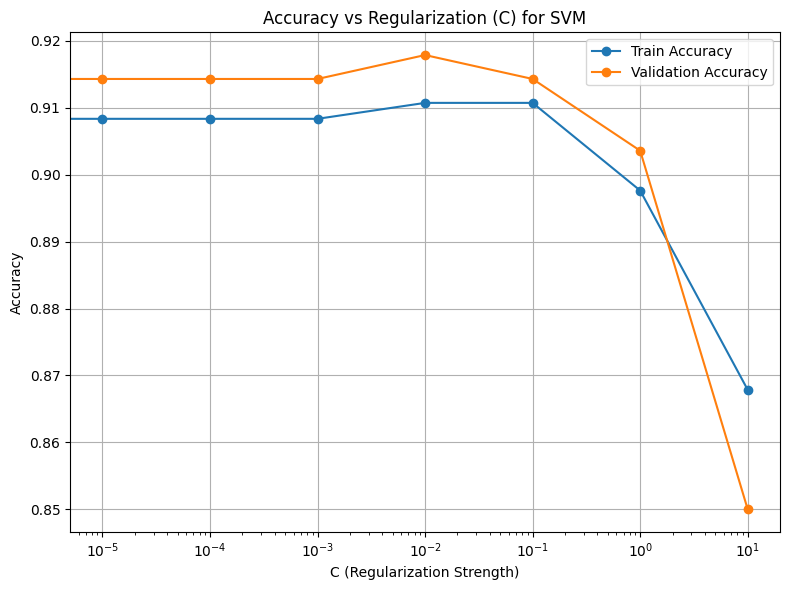

In [87]:
train_nn((32,), 'logistic', alpha)

### a2) 3 Layer (14 -> 32 -> 1) - reLu

      Alpha  Train Accuracy  Validation Accuracy  Train Precision  \
0   0.00000        0.978571             0.921429         0.985507   
1   0.00001        0.978571             0.921429         0.985507   
2   0.00010        0.978571             0.921429         0.985507   
3   0.00100        0.978571             0.921429         0.985507   
4   0.01000        0.975000             0.921429         0.983051   
5   0.10000        0.957143             0.925000         0.968293   
6   1.00000        0.919048             0.917857         0.931373   
7  10.00000        0.890476             0.892857         0.916244   

   Validation Precision  Train Recall  Validation Recall  
0              0.975806      0.971429           0.864286  
1              0.975806      0.971429           0.864286  
2              0.975806      0.971429           0.864286  
3              0.975806      0.971429           0.864286  
4              0.975806      0.966667           0.864286  
5              0.976000 

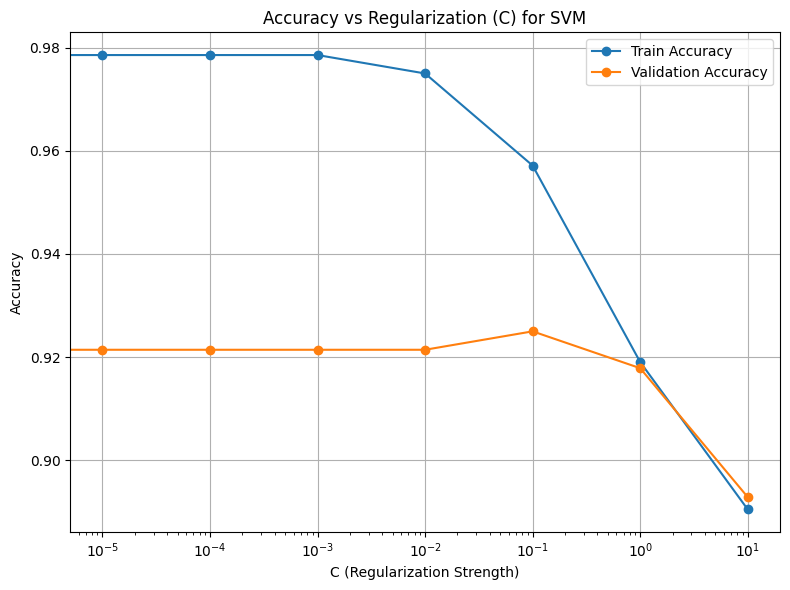

In [88]:
train_nn((32,), 'relu', alpha)

### a3) 3 Layer (14 -> 32 -> 1) - tanh

      Alpha  Train Accuracy  Validation Accuracy  Train Precision  \
0   0.00000        0.971429             0.921429         0.975962   
1   0.00001        0.971429             0.921429         0.975962   
2   0.00010        0.971429             0.921429         0.975962   
3   0.00100        0.972619             0.921429         0.978313   
4   0.01000        0.972619             0.925000         0.978313   
5   0.10000        0.955952             0.928571         0.963680   
6   1.00000        0.913095             0.914286         0.926290   
7  10.00000        0.890476             0.892857         0.918367   

   Validation Precision  Train Recall  Validation Recall  
0              0.975806      0.966667           0.864286  
1              0.975806      0.966667           0.864286  
2              0.975806      0.966667           0.864286  
3              0.975806      0.966667           0.864286  
4              0.976000      0.966667           0.871429  
5              0.968750 

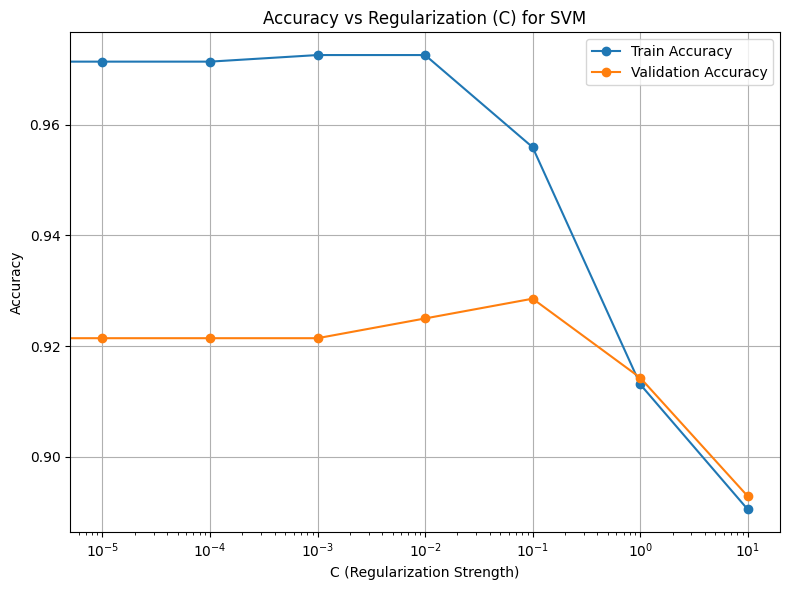

In [89]:
train_nn((32,), 'tanh', alpha)

### b) 3 Layer (14 -> 64 -> 1) - sigmoid

      Alpha  Train Accuracy  Validation Accuracy  Train Precision  \
0   0.00000        0.914286             0.914286         0.932836   
1   0.00001        0.914286             0.914286         0.932836   
2   0.00010        0.914286             0.914286         0.932836   
3   0.00100        0.914286             0.914286         0.932836   
4   0.01000        0.913095             0.917857         0.926290   
5   0.10000        0.902381             0.910714         0.928934   
6   1.00000        0.898810             0.903571         0.921914   
7  10.00000        0.872619             0.867857         0.921833   

   Validation Precision  Train Recall  Validation Recall  
0              0.960317      0.892857           0.864286  
1              0.960317      0.892857           0.864286  
2              0.960317      0.892857           0.864286  
3              0.960317      0.892857           0.864286  
4              0.960630      0.897619           0.871429  
5              0.960000 

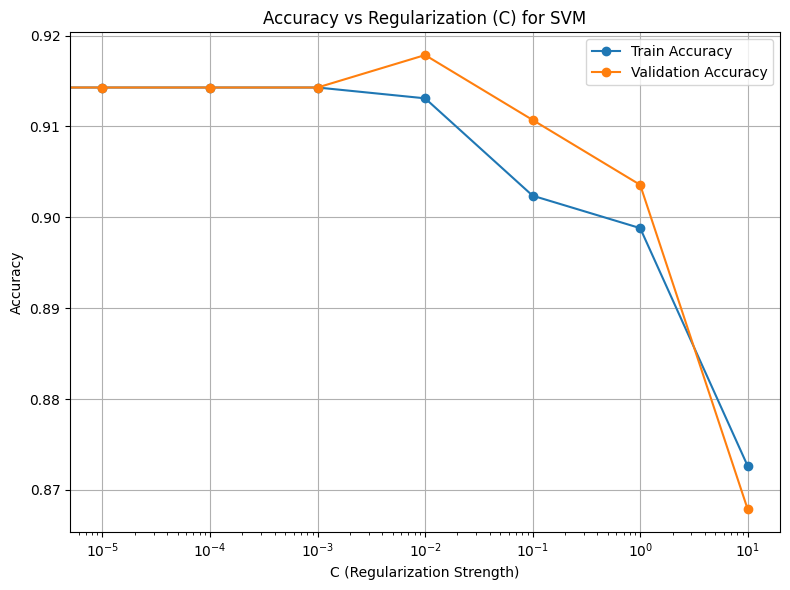

In [90]:
train_nn((64,), 'logistic', alpha)

### c) 3 Layer (14 -> 128 -> 1) - sigmoid

      Alpha  Train Accuracy  Validation Accuracy  Train Precision  \
0   0.00000        0.910714             0.914286         0.925926   
1   0.00001        0.910714             0.914286         0.925926   
2   0.00010        0.910714             0.914286         0.925926   
3   0.00100        0.910714             0.910714         0.936709   
4   0.01000        0.905952             0.910714         0.931646   
5   0.10000        0.911905             0.914286         0.928218   
6   1.00000        0.898810             0.903571         0.921914   
7  10.00000        0.867857             0.850000         0.927978   

   Validation Precision  Train Recall  Validation Recall  
0              0.960317      0.892857           0.864286  
1              0.960317      0.892857           0.864286  
2              0.960317      0.892857           0.864286  
3              0.960000      0.880952           0.857143  
4              0.960000      0.876190           0.857143  
5              0.960317 

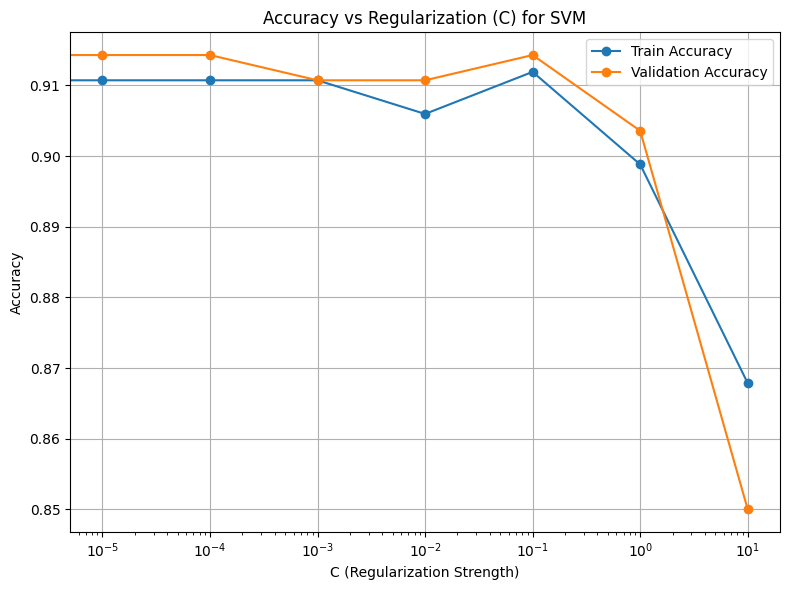

In [92]:
train_nn((128,), 'logistic', alpha)

### d) 4 Layer (14 -> 64 -> 64 -> 1) - sigmoid

      Alpha  Train Accuracy  Validation Accuracy  Train Precision  \
0   0.00000        0.920238             0.928571         0.935802   
1   0.00001        0.920238             0.928571         0.935802   
2   0.00010        0.920238             0.928571         0.935802   
3   0.00100        0.920238             0.928571         0.935802   
4   0.01000        0.913095             0.925000         0.926290   
5   0.10000        0.908333             0.914286         0.929825   
6   1.00000        0.897619             0.903571         0.921717   
7  10.00000        0.500000             0.500000         0.000000   

   Validation Precision  Train Recall  Validation Recall  
0              0.968750      0.902381           0.885714  
1              0.968750      0.902381           0.885714  
2              0.968750      0.902381           0.885714  
3              0.968750      0.902381           0.885714  
4              0.961240      0.897619           0.885714  
5              0.960317 

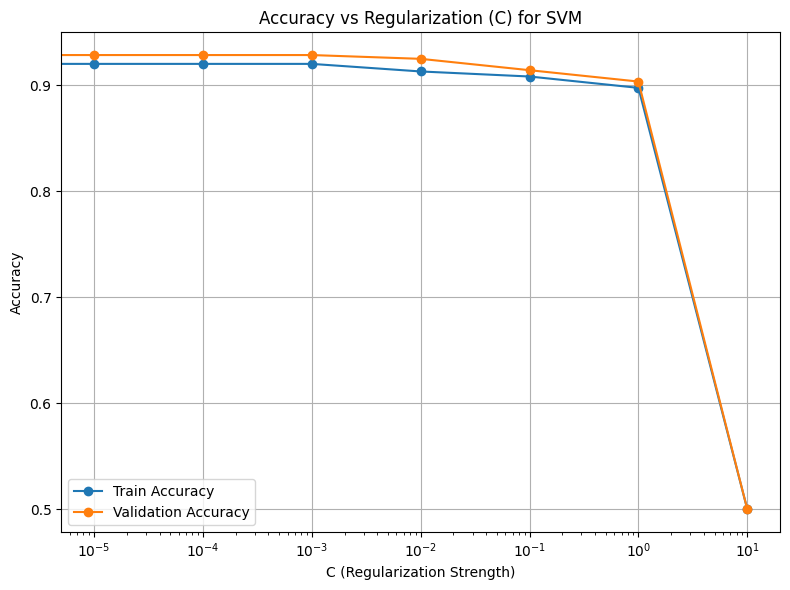

In [93]:
train_nn((64, 64,), 'logistic', alpha)

### e) 5 Layer (14 -> 64 -> 64 -> 64 -> 1) - sigmoid

      Alpha  Train Accuracy  Validation Accuracy  Train Precision  \
0   0.00000        0.925000             0.928571         0.920000   
1   0.00001        0.925000             0.928571         0.920000   
2   0.00010        0.925000             0.928571         0.920000   
3   0.00100        0.922619             0.928571         0.921615   
4   0.01000        0.922619             0.928571         0.921615   
5   0.10000        0.909524             0.910714         0.932161   
6   1.00000        0.500000             0.500000         0.000000   
7  10.00000        0.500000             0.500000         0.000000   

   Validation Precision  Train Recall  Validation Recall  
0              0.954545      0.930952           0.900000  
1              0.954545      0.930952           0.900000  
2              0.954545      0.930952           0.900000  
3              0.954545      0.923810           0.900000  
4              0.954545      0.923810           0.900000  
5              0.960000 

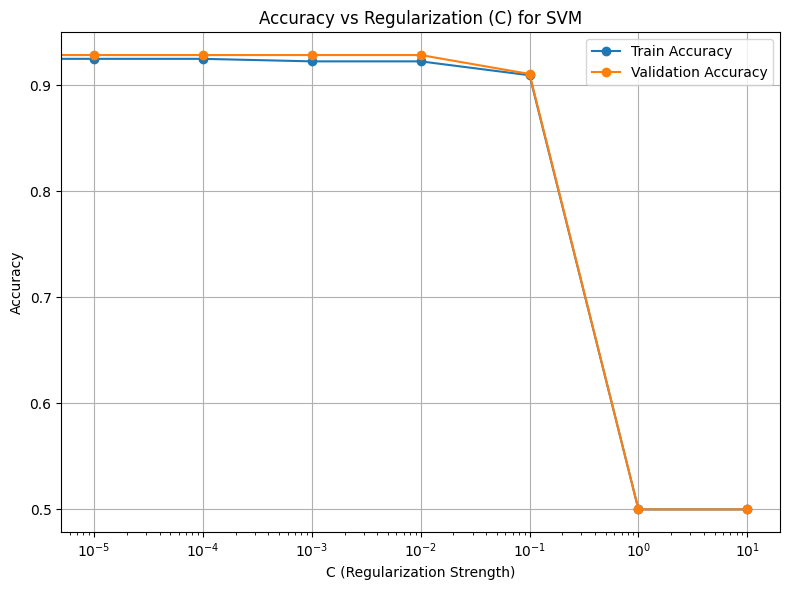

In [94]:
train_nn((64, 64, 64,), 'logistic', alpha)